# Compiling & Visualizing Tracr Models

This notebook demonstrates how to compile a tracr model and provides some tools visualize the model's residual stream or layer outputs for a given input sequence.

In [18]:
import jax
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# The default of float16 can lead to discrepancies between outputs of
# the compiled model and the RASP program.
jax.config.update('jax_default_matmul_precision', 'float32')

from tracr.compiler import compiling
from tracr.compiler import lib
from tracr.rasp import rasp

In [2]:
#@title Plotting functions
def tidy_label(label, value_width=5):
  if ':' in label:
    label, value = label.split(':')
  else:
    value = ''
  return label + f":{value:>{value_width}}"


def add_residual_ticks(model, value_width=5, x=False, y=True):
  if y:
    plt.yticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            fontsize=20,
    )
  if x:
    plt.xticks(
            np.arange(len(model.residual_labels))+0.5, 
            [tidy_label(l, value_width=value_width)
              for l in model.residual_labels], 
            family='monospace',
            rotation=90,
            fontsize=20,
    )


def plot_computation_trace(model,
                           input_labels,
                           residuals_or_outputs,
                           add_input_layer=False,
                           figsize=(12, 9)):
  fig, axes = plt.subplots(nrows=1, ncols=len(residuals_or_outputs), figsize=figsize, sharey=True)
  value_width = max(map(len, map(str, input_labels))) + 1

  for i, (layer, ax) in enumerate(zip(residuals_or_outputs, axes)):
    plt.sca(ax)
    plt.pcolormesh(layer[0].T, vmin=0, vmax=1)
    if i == 0:
      add_residual_ticks(model, value_width=value_width)
    plt.xticks(
        np.arange(len(input_labels))+0.5,
        input_labels,
        rotation=90,
        fontsize=20,
    )
    if add_input_layer and i == 0:
      title = 'Input'
    else:
      layer_no = i - 1 if add_input_layer else i
      layer_type = 'Attn' if layer_no % 2 == 0 else 'MLP'
      title = f'{layer_type} {layer_no // 2 + 1}'
    plt.title(title, fontsize=20)


def plot_residuals_and_input(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the residual stream at each layer."""
  model_out = model.apply(inputs)
  residuals = np.concatenate([model_out.input_embeddings[None, ...],
                              model_out.residuals], axis=0)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=residuals,
      add_input_layer=True,
      figsize=figsize)


def plot_layer_outputs(model, inputs, figsize=(12, 9)):
  """Applies model to inputs, and plots the outputs of each layer."""
  model_out = model.apply(inputs)
  plot_computation_trace(
      model=model,
      input_labels=inputs,
      residuals_or_outputs=model_out.layer_outputs,
      add_input_layer=False,
      figsize=figsize)


In [3]:
#@title Define RASP programs
def get_program(program_name, max_seq_len):
  """Returns RASP program and corresponding token vocabulary."""
  if program_name == "length":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_length()
  elif program_name == "frac_prevs":
    vocab = {"a", "b", "c", "x"}
    program = lib.make_frac_prevs((rasp.tokens == "x").named("is_x"))
  elif program_name == "dyck-2":
    vocab = {"(", ")", "{", "}"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}"])
  elif program_name == "dyck-3":
    vocab = {"(", ")", "{", "}", "[", "]"}
    program = lib.make_shuffle_dyck(pairs=["()", "{}", "[]"])
  elif program_name == "sort":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort(
        rasp.tokens, rasp.tokens, max_seq_len=max_seq_len, min_key=1)
  elif program_name == "sort_unique":
    vocab = {1, 2, 3, 4, 5}
    program = lib.make_sort_unique(rasp.tokens, rasp.tokens)
  elif program_name == "hist":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_hist()
  elif program_name == "sort_freq":
    vocab = {"a", "b", "c", "d"}
    program = lib.make_sort_freq(max_seq_len=max_seq_len)
  elif program_name == "pair_balance":
    vocab = {"(", ")"}
    program = lib.make_pair_balance(
        sop=rasp.tokens, open_token="(", close_token=")")
  else:
    raise NotImplementedError(f"Program {program_name} not implemented.")
  return program, vocab

In [4]:
#@title: Assemble model
program_name = "pair_balance"  #@param ["length", "frac_prevs", "dyck-2", "dyck-3", "sort", "sort_unique", "hist", "sort_freq", "pair_balance"]
max_seq_len = 100  #@param {label: "Test", type: "integer"}

program, vocab = get_program(program_name=program_name,
                             max_seq_len=max_seq_len)

print(f"Compiling...")
print(f"   Program: {program_name}")
print(f"   Input vocabulary: {vocab}")
print(f"   Context size: {max_seq_len}")

assembled_model = compiling.compile_rasp_to_model(
      program=program,
      vocab=vocab,
      max_seq_len=max_seq_len,
      causal=False,
      compiler_bos="bos",
      compiler_pad="pad",
      mlp_exactness=100)

print("Done.")

Compiling...
   Program: pair_balance
   Input vocabulary: {'(', ')'}
   Context size: 100
Done.


In [5]:
type(assembled_model)

tracr.compiler.assemble.AssembledTransformerModel

In [6]:
assembled_model.apply(["bos", "(", "(", ")","(", ")","(", ")", ")", "("]).decoded

['bos',
 0.9925767183303833,
 0.9962745308876038,
 0.3325154185295105,
 0.4990730881690979,
 0.19970926642417908,
 0.33292388916015625,
 0.14271080493927002,
 6.258487701416016e-06,
 0.11102378368377686]

In [7]:
assembled_model.apply(['bos', '(', '(', ')', ')', '(', ')']).decoded

['bos',
 0.9926750063896179,
 0.9963240623474121,
 0.3325154781341553,
 0.0,
 0.19970527291297913,
 0.0]

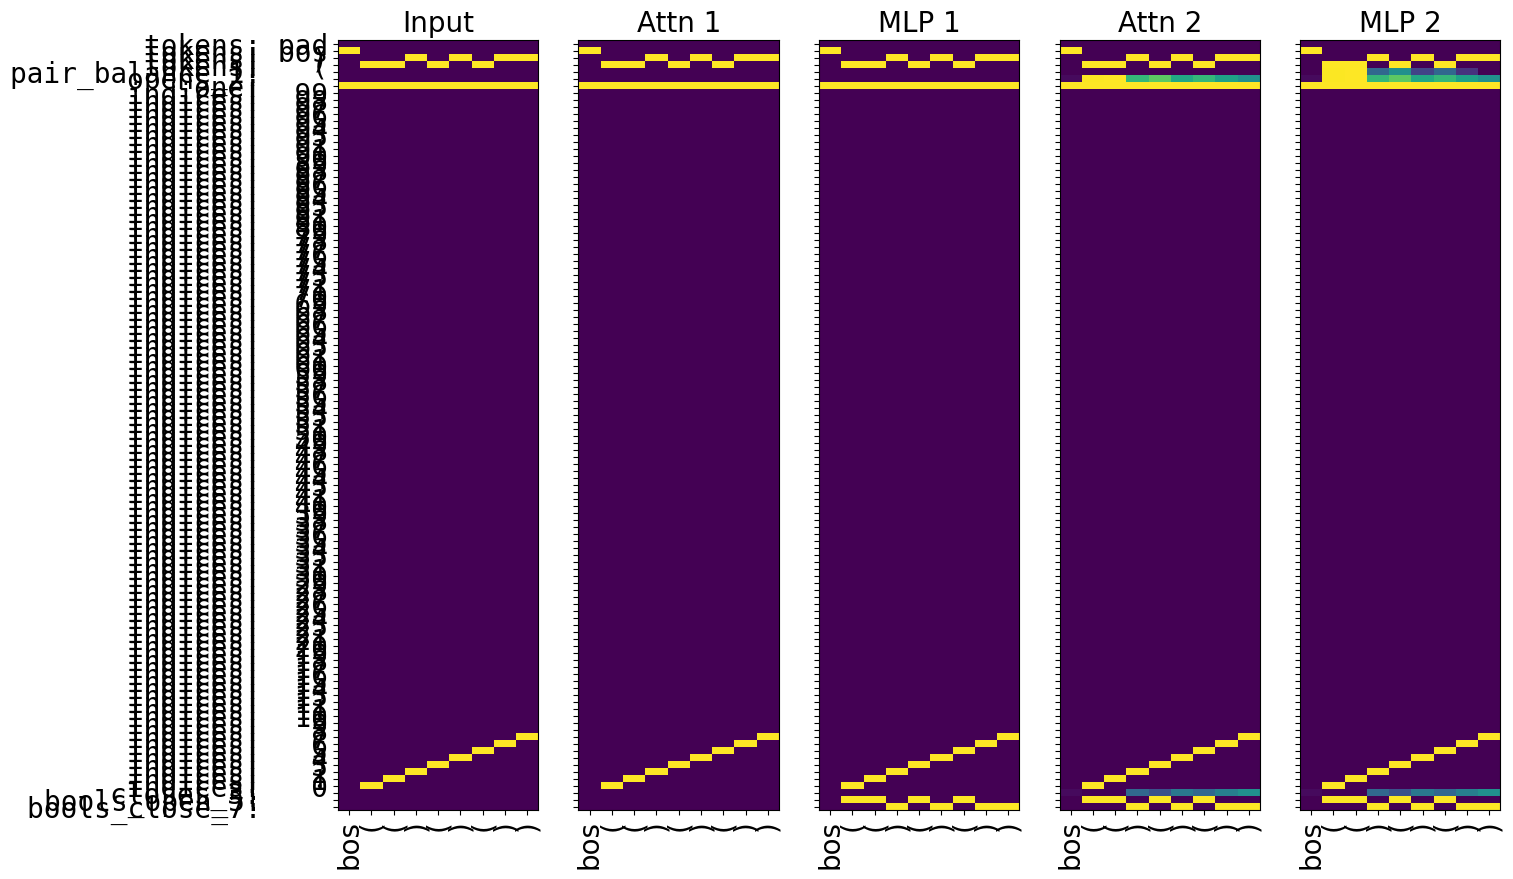

In [8]:
#@title Plot residual stream
plot_residuals_and_input(
  model=assembled_model,
  
  inputs=["bos", "(", "(", ")","(", ")","(", ")", ")"],
  figsize=(15, 10)
)

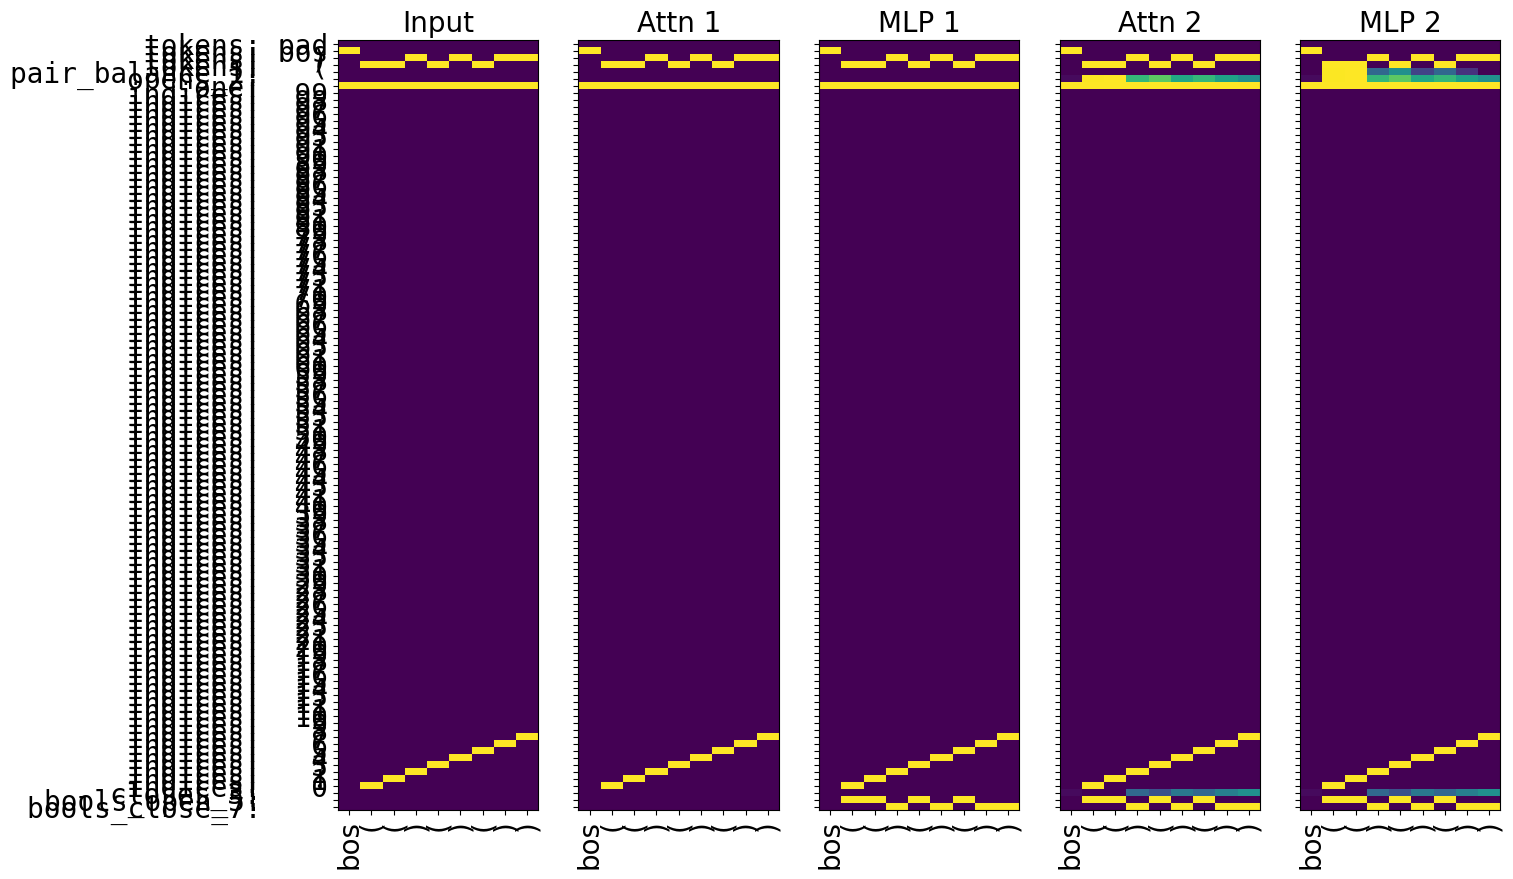

In [9]:
#@title Plot layer outputs
plot_residuals_and_input(
  model=assembled_model,
  inputs = ["bos", "(", "(", ")","(", ")","(", ")", ")"],
  figsize=(15, 10)
)

In [13]:
# balanced = generate_balanced_parentheses(50)
for i in range(1000):
  paren = generate_balanced_parentheses(50)
  if(assembled_model.apply(paren).decoded[-1] != 0):
    print(paren)


In [29]:
import random
import numpy as np
import torch

def generate_balanced_parentheses(max_len=95):
    """
    Generate a random sequence of balanced parentheses.
    
    Args:
        max_len (int): Maximum length of the sequence
    
    Returns:
        list: A list of balanced parentheses tokens
    """
    def is_valid_sequence(sequence):
        """Check if a sequence of parentheses is balanced."""
        stack = []
        for token in sequence:
            if token == '(':
                stack.append(token)
            elif token == ')':
                if not stack:
                    return False
                stack.pop()
        return len(stack) == 0

    while True:
        # Generate a random length
        length = random.randint(2, max_len)
        # Ensure even length for balanced parentheses
        if length % 2 != 0:
            length += 1
        
        # Generate random sequence
        sequence = []
        remaining_open = length // 2
        remaining_close = length // 2
        
        while len(sequence) < length:
            # Decide whether to add an open or close parenthesis
            if remaining_open == 0:
                sequence.append(')')
                remaining_close -= 1
            elif remaining_close == 0:
                sequence.append('(')
                remaining_open -= 1
            else:
                # Probabilistic choice
                choice = random.choice(['(', ')'])
                if choice == '(' and remaining_open > 0:
                    sequence.append('(')
                    remaining_open -= 1
                elif choice == ')' and remaining_close > 0 and len(sequence) > len(sequence) - remaining_close:
                    sequence.append(')')
                    remaining_close -= 1
                else:
                    # Fallback if constraints are not met
                    sequence.append('(')
                    remaining_open -= 1
        
        # Validate the sequence
        if is_valid_sequence(sequence):
            # Prepend BOS token
            return ['bos'] + sequence

def calculate_stack_lengths(sequence):
    """
    Calculate stack lengths for each token position.
    
    Args:
        sequence (list): A sequence of tokens
    
    Returns:
        list: Stack lengths at each token position
    """
    stack_lengths = []
    stack = []
    
    for token in sequence:
        if token == 'bos':
            stack_lengths.append(0)
        elif token == '(':
            stack.append(token)
            stack_lengths.append(len(stack))
        elif token == ')':
            if stack:
                stack.pop()
            stack_lengths.append(len(stack))
    
    return stack_lengths

def generate_control_dataset(model, num_sequences=1000, max_len=50):
    """
    Generate a control dataset with randomly initialized targets.
    
    Args:
        model: The compiled model for extracting residuals
        num_sequences (int): Number of sequences to generate
        max_len (int): Maximum length of sequences
    
    Returns:
        tuple: (inputs, random labels)
    """
    inputs = []
    labels = []
    
    for _ in range(num_sequences):
        # Generate a balanced parentheses sequence
        sequence = generate_balanced_parentheses(max_len)
        
        # Extract residuals from the model
        model_output = model.apply(sequence)
        residuals = model_output.residuals
        
        # Concatenate residuals from all layers (optional)
        combined_residuals = np.concatenate(residuals, axis=-1)
        
        # Extract token-level residuals (skip BOS token)
        for i in range(1, len(sequence)):
            inputs.append(combined_residuals[0, i, :])
            # Randomly initialize labels
            labels.append(random.uniform(0, 10))
    
    return np.array(inputs), np.array(labels)

def generate_dataset(model, num_sequences=1000, max_len=50):
    """
    Generate a dataset of balanced parentheses sequences.
    
    Args:
        model: The compiled model for extracting residuals
        num_sequences (int): Number of sequences to generate
        max_len (int): Maximum length of sequences
    
    Returns:
        tuple: (inputs, labels)
    """
    inputs = []
    labels = []
    
    for _ in range(num_sequences):
        # Generate a balanced parentheses sequence
        sequence = generate_balanced_parentheses(max_len)
        
        # Calculate stack lengths
        stack_lengths = calculate_stack_lengths(sequence)
        
        # Extract residuals from the model
        model_output = model.apply(sequence)
        residuals = model_output.residuals
        
        # Concatenate residuals from all layers (optional)
        combined_residuals = np.concatenate(residuals, axis=-1)
        
        # Extract token-level residuals (skip BOS token)
        for i in range(1, len(sequence)):
            inputs.append(combined_residuals[0, i, :])
            labels.append(stack_lengths[i])
    
    return np.array(inputs), np.array(labels)

class StackDepthRegressor(nn.Module):
    def __init__(self, input_size):
        """
        Regression model for stack depth prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackDepthRegressor, self).__init__()
        # Multi-layer architecture for more complex regression
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Single output for stack depth
        )
    
    def forward(self, x):
        return self.layers(x).squeeze()

class StackDepthRegressorFour(nn.Module):
    def __init__(self, input_size):
        """
        Regression model for stack depth prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackDepthRegressorFour, self).__init__()
        # Multi-layer architecture for more complex regression
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)  # Single output for stack depth
        )
    
    def forward(self, x):
        return self.layers(x).squeeze()

class StackDepthRegressorTwo(nn.Module):
    def __init__(self, input_size):
        """
        Regression model for stack depth prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackDepthRegressorTwo, self).__init__()
        # Multi-layer architecture for more complex regression
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1)# Single output for stack depth
        )
    
    def forward(self, x):
        return self.layers(x).squeeze()

class StackDepthRegressorThree(nn.Module):
    def __init__(self, input_size):
        """
        Regression model for stack depth prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackDepthRegressorThree, self).__init__()
        # Multi-layer architecture for more complex regression
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1) # Single output for stack depth
        )
    
    def forward(self, x):
        return self.layers(x).squeeze()

def train_and_evaluate(X, y, probe_model):
    """
    Train a regression model and evaluate its performance
    
    Args:
        X (np.array): Input features
        y (np.array): Stack depth labels
    
    Returns:
        dict: Training history with metrics
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    acc = []
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Instantiate the model
    input_size = X_train.shape[1]
    # model = StackDepthRegressor(input_size)
    model = probe_model
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training parameters
    epochs = 500
    
    # Training history
    train_losses = []
    test_losses = []
    train_mae = []
    test_mae = []
    
    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Compute training metrics
        with torch.no_grad():
            train_loss = loss.item()
            train_losses.append(train_loss)
            train_mae.append(torch.mean(torch.abs(outputs - y_train_tensor)).item())
        
        # Compute test metrics
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor).item()
            test_losses.append(test_loss)
            test_mae.append(torch.mean(torch.abs(test_outputs - y_test_tensor)).item())
            output = model(X_test_tensor)

        rounded_output = torch.round(output)
        correct_predictions = (rounded_output == y_test_tensor).sum().item()
        accuracy = correct_predictions / y_test_tensor.shape[0]
        acc.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {test_loss:.4f} - MAE: {test_mae[-1]:.4f} - Accuracy: {accuracy:.4f}")
    
    # Plotting
    plt.figure(figsize=(12, 4))
    
    # MSE Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss (MSE)')
    plt.plot(test_losses, label='Testing Loss (MSE)')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    
    # MAE Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_mae, label='Training MAE')
    plt.plot(test_mae, label='Testing MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'train_losses': train_losses, 
        'test_losses': test_losses,
        'train_mae': train_mae,
        'test_mae': test_mae,
    }, acc

In [32]:
def train_and_evaluate_control(X, y, probe_model):
    """
    Train a regression model and evaluate its performance
    
    Args:
        X (np.array): Input features
        y (np.array): Stack depth labels
    
    Returns:
        dict: Training history with metrics
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    acc = []
    train_acc = []
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.FloatTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Instantiate the model
    input_size = X_train.shape[1]
    # model = StackDepthRegressor(input_size)
    model = probe_model
    
    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training parameters
    epochs = 500
    
    # Training history
    train_losses = []
    test_losses = []
    train_mae = []
    test_mae = []
    
    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Compute training metrics
        with torch.no_grad():
            train_loss = loss.item()
            train_losses.append(train_loss)
            train_mae.append(torch.mean(torch.abs(outputs - y_train_tensor)).item())
        
        rounded_output = torch.round(outputs)
        correct_predictions = (rounded_output == y_train_tensor).sum().item()
        accuracy = correct_predictions / y_train_tensor.shape[0]
        train_acc.append(accuracy)

        
        # Compute test metrics
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor).item()
            test_losses.append(test_loss)
            test_mae.append(torch.mean(torch.abs(test_outputs - y_test_tensor)).item())
            output = model(X_test_tensor)

        rounded_output = torch.round(output)
        correct_predictions = (rounded_output == y_test_tensor).sum().item()
        accuracy = correct_predictions / y_test_tensor.shape[0]
        acc.append(accuracy)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {test_loss:.4f} - MAE: {test_mae[-1]:.4f} - Accuracy: {accuracy:.4f}")
    
    # Plotting
    plt.figure(figsize=(12, 4))
    
    # MSE Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss (MSE)')
    plt.plot(test_losses, label='Testing Loss (MSE)')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    
    # MAE Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_mae, label='Training MAE')
    plt.plot(test_mae, label='Testing MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return {
        'train_losses': train_losses, 
        'test_losses': test_losses,
        'train_mae': train_mae,
        'test_mae': test_mae,
    }, acc, train_acc

In [27]:
if __name__ == "__main__":
    # Set random seeds for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)
    random.seed(42)
    
    # Create a mock model (replace with your actual model)
    mock_model = assembled_model
    
    # Generate dataset
    X, y = generate_dataset(mock_model, num_sequences=1000)
    
    # Generate control dataset
    X_control, y_control = generate_control_dataset(mock_model, num_sequences=1000)
    


Stack Depth Regression Results:
Epoch 1/500 - Loss: 20.9397 - MAE: 3.6399 - Accuracy: 0.0585
Epoch 2/500 - Loss: 20.8599 - MAE: 3.6379 - Accuracy: 0.0545
Epoch 3/500 - Loss: 20.7817 - MAE: 3.6360 - Accuracy: 0.0566
Epoch 4/500 - Loss: 20.7049 - MAE: 3.6341 - Accuracy: 0.0564
Epoch 5/500 - Loss: 20.6296 - MAE: 3.6327 - Accuracy: 0.0529
Epoch 6/500 - Loss: 20.5558 - MAE: 3.6314 - Accuracy: 0.0529
Epoch 7/500 - Loss: 20.4835 - MAE: 3.6304 - Accuracy: 0.0529
Epoch 8/500 - Loss: 20.4128 - MAE: 3.6295 - Accuracy: 0.0555
Epoch 9/500 - Loss: 20.3438 - MAE: 3.6287 - Accuracy: 0.0475
Epoch 10/500 - Loss: 20.2763 - MAE: 3.6278 - Accuracy: 0.0463
Epoch 11/500 - Loss: 20.2104 - MAE: 3.6269 - Accuracy: 0.0447
Epoch 12/500 - Loss: 20.1460 - MAE: 3.6262 - Accuracy: 0.0337
Epoch 13/500 - Loss: 20.0832 - MAE: 3.6254 - Accuracy: 0.0377
Epoch 14/500 - Loss: 20.0219 - MAE: 3.6247 - Accuracy: 0.0365
Epoch 15/500 - Loss: 19.9620 - MAE: 3.6240 - Accuracy: 0.0365
Epoch 16/500 - Loss: 19.9035 - MAE: 3.6233 - Ac

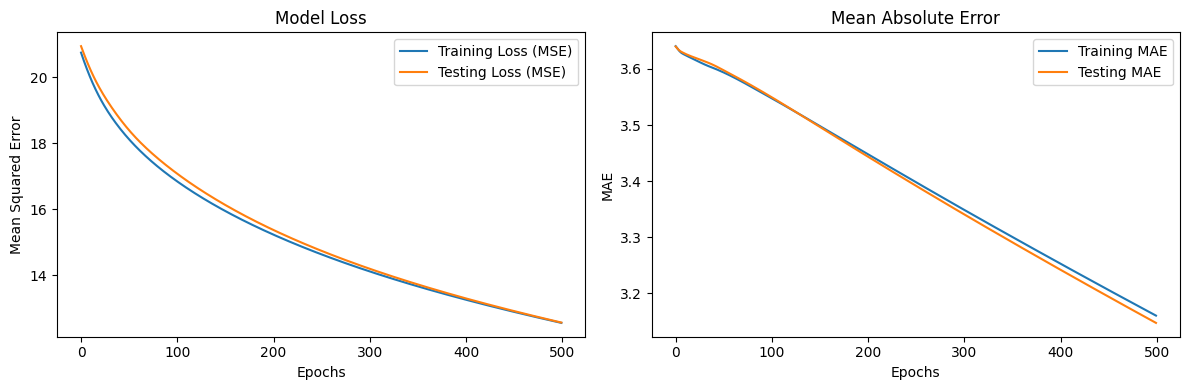

Epoch 1/500 - Loss: 20.2098 - MAE: 3.5585 - Accuracy: 0.0749
Epoch 2/500 - Loss: 19.7085 - MAE: 3.5036 - Accuracy: 0.0735
Epoch 3/500 - Loss: 19.2273 - MAE: 3.4506 - Accuracy: 0.0742
Epoch 4/500 - Loss: 18.7652 - MAE: 3.3988 - Accuracy: 0.0740
Epoch 5/500 - Loss: 18.3212 - MAE: 3.3482 - Accuracy: 0.0777
Epoch 6/500 - Loss: 17.8950 - MAE: 3.2986 - Accuracy: 0.0831
Epoch 7/500 - Loss: 17.4844 - MAE: 3.2501 - Accuracy: 0.0817
Epoch 8/500 - Loss: 17.0894 - MAE: 3.2027 - Accuracy: 0.0826
Epoch 9/500 - Loss: 16.7086 - MAE: 3.1563 - Accuracy: 0.0932
Epoch 10/500 - Loss: 16.3405 - MAE: 3.1109 - Accuracy: 0.0932
Epoch 11/500 - Loss: 15.9839 - MAE: 3.0663 - Accuracy: 0.0960
Epoch 12/500 - Loss: 15.6333 - MAE: 3.0219 - Accuracy: 0.0901
Epoch 13/500 - Loss: 15.2906 - MAE: 2.9781 - Accuracy: 0.0981
Epoch 14/500 - Loss: 14.9534 - MAE: 2.9346 - Accuracy: 0.0964
Epoch 15/500 - Loss: 14.6202 - MAE: 2.8918 - Accuracy: 0.1021
Epoch 16/500 - Loss: 14.2913 - MAE: 2.8490 - Accuracy: 0.1199
Epoch 17/500 - Lo

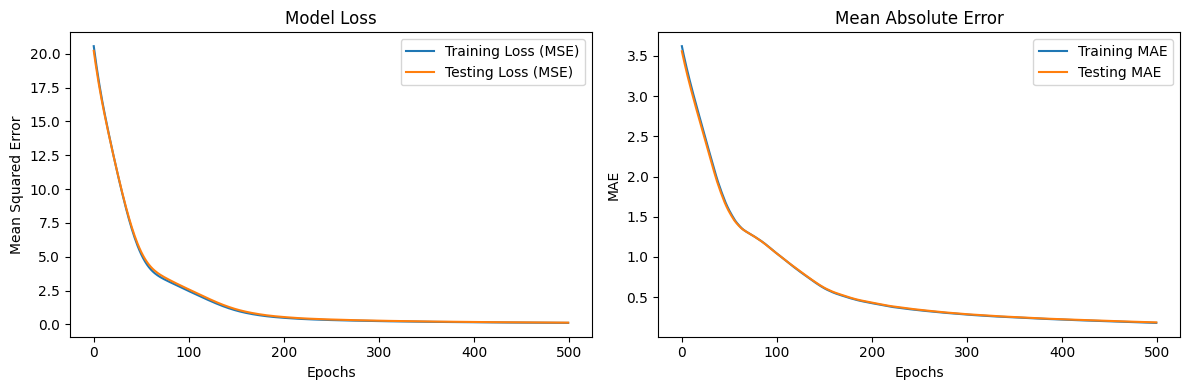

Epoch 1/500 - Loss: 20.2015 - MAE: 3.5537 - Accuracy: 0.0749
Epoch 2/500 - Loss: 19.9580 - MAE: 3.5245 - Accuracy: 0.0749
Epoch 3/500 - Loss: 19.7386 - MAE: 3.4987 - Accuracy: 0.0749
Epoch 4/500 - Loss: 19.5399 - MAE: 3.4752 - Accuracy: 0.0749
Epoch 5/500 - Loss: 19.3614 - MAE: 3.4541 - Accuracy: 0.0763
Epoch 6/500 - Loss: 19.2036 - MAE: 3.4351 - Accuracy: 0.0763
Epoch 7/500 - Loss: 19.0558 - MAE: 3.4171 - Accuracy: 0.0763
Epoch 8/500 - Loss: 18.9102 - MAE: 3.3994 - Accuracy: 0.0754
Epoch 9/500 - Loss: 18.7608 - MAE: 3.3813 - Accuracy: 0.0754
Epoch 10/500 - Loss: 18.6034 - MAE: 3.3623 - Accuracy: 0.0763
Epoch 11/500 - Loss: 18.4356 - MAE: 3.3419 - Accuracy: 0.0765
Epoch 12/500 - Loss: 18.2584 - MAE: 3.3203 - Accuracy: 0.0789
Epoch 13/500 - Loss: 18.0708 - MAE: 3.2972 - Accuracy: 0.0857
Epoch 14/500 - Loss: 17.8706 - MAE: 3.2725 - Accuracy: 0.0854
Epoch 15/500 - Loss: 17.6574 - MAE: 3.2461 - Accuracy: 0.0866
Epoch 16/500 - Loss: 17.4316 - MAE: 3.2179 - Accuracy: 0.0894
Epoch 17/500 - Lo

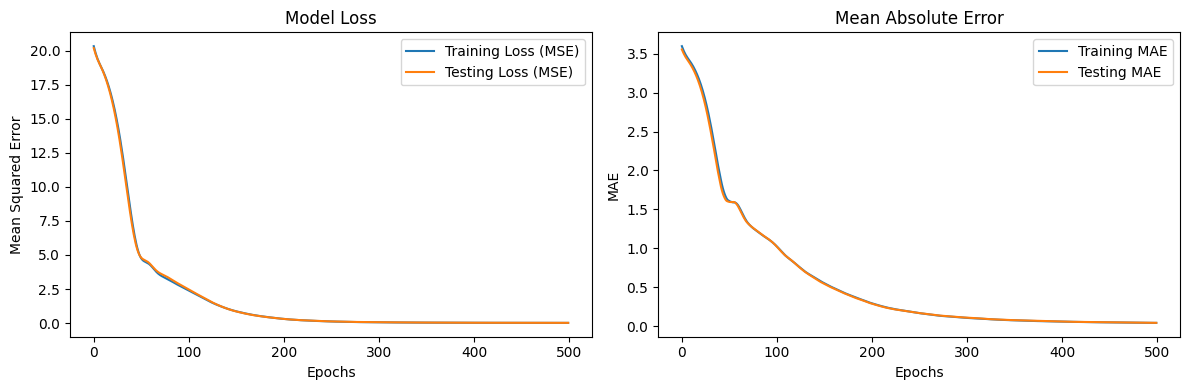

Epoch 1/500 - Loss: 20.0916 - MAE: 3.5391 - Accuracy: 0.0749
Epoch 2/500 - Loss: 19.9475 - MAE: 3.5227 - Accuracy: 0.0749
Epoch 3/500 - Loss: 19.8057 - MAE: 3.5063 - Accuracy: 0.0749
Epoch 4/500 - Loss: 19.6653 - MAE: 3.4899 - Accuracy: 0.0749
Epoch 5/500 - Loss: 19.5258 - MAE: 3.4735 - Accuracy: 0.0749
Epoch 6/500 - Loss: 19.3843 - MAE: 3.4567 - Accuracy: 0.0749
Epoch 7/500 - Loss: 19.2393 - MAE: 3.4394 - Accuracy: 0.0749
Epoch 8/500 - Loss: 19.0903 - MAE: 3.4215 - Accuracy: 0.0749
Epoch 9/500 - Loss: 18.9352 - MAE: 3.4027 - Accuracy: 0.0749
Epoch 10/500 - Loss: 18.7722 - MAE: 3.3829 - Accuracy: 0.0749
Epoch 11/500 - Loss: 18.5995 - MAE: 3.3619 - Accuracy: 0.0751
Epoch 12/500 - Loss: 18.4160 - MAE: 3.3395 - Accuracy: 0.0765
Epoch 13/500 - Loss: 18.2212 - MAE: 3.3156 - Accuracy: 0.0772
Epoch 14/500 - Loss: 18.0130 - MAE: 3.2900 - Accuracy: 0.0761
Epoch 15/500 - Loss: 17.7913 - MAE: 3.2626 - Accuracy: 0.0765
Epoch 16/500 - Loss: 17.5548 - MAE: 3.2331 - Accuracy: 0.0805
Epoch 17/500 - Lo

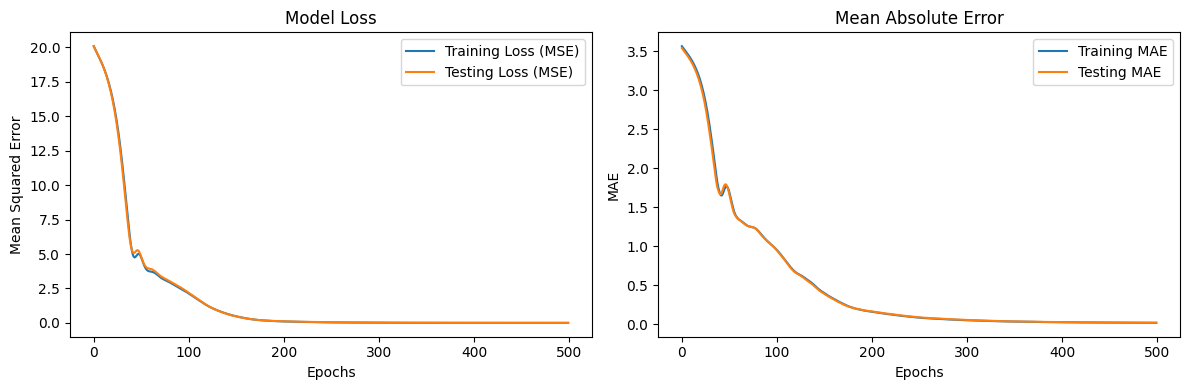


Control Task Regression Results:
Epoch 1/500 - Loss: 31.1618 - MAE: 4.6167 - Accuracy: 0.0000
Epoch 2/500 - Loss: 31.0802 - MAE: 4.6119 - Accuracy: 0.0000
Epoch 3/500 - Loss: 30.9998 - MAE: 4.6072 - Accuracy: 0.0000
Epoch 4/500 - Loss: 30.9202 - MAE: 4.6025 - Accuracy: 0.0000
Epoch 5/500 - Loss: 30.8418 - MAE: 4.5980 - Accuracy: 0.0000
Epoch 6/500 - Loss: 30.7648 - MAE: 4.5934 - Accuracy: 0.0000
Epoch 7/500 - Loss: 30.6894 - MAE: 4.5889 - Accuracy: 0.0000
Epoch 8/500 - Loss: 30.6157 - MAE: 4.5845 - Accuracy: 0.0000
Epoch 9/500 - Loss: 30.5439 - MAE: 4.5802 - Accuracy: 0.0000
Epoch 10/500 - Loss: 30.4740 - MAE: 4.5759 - Accuracy: 0.0000
Epoch 11/500 - Loss: 30.4060 - MAE: 4.5717 - Accuracy: 0.0000
Epoch 12/500 - Loss: 30.3401 - MAE: 4.5677 - Accuracy: 0.0000
Epoch 13/500 - Loss: 30.2761 - MAE: 4.5638 - Accuracy: 0.0000
Epoch 14/500 - Loss: 30.2143 - MAE: 4.5600 - Accuracy: 0.0000
Epoch 15/500 - Loss: 30.1544 - MAE: 4.5564 - Accuracy: 0.0000
Epoch 16/500 - Loss: 30.0966 - MAE: 4.5528 - 

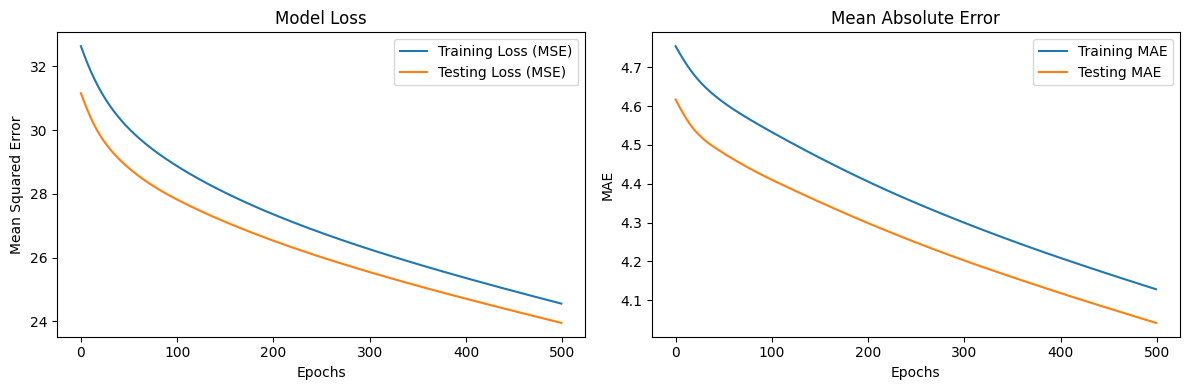

Epoch 1/500 - Loss: 15.8558 - MAE: 3.2498 - Accuracy: 0.0000
Epoch 2/500 - Loss: 15.4350 - MAE: 3.2076 - Accuracy: 0.0000
Epoch 3/500 - Loss: 15.0667 - MAE: 3.1712 - Accuracy: 0.0000
Epoch 4/500 - Loss: 14.7398 - MAE: 3.1383 - Accuracy: 0.0000
Epoch 5/500 - Loss: 14.4537 - MAE: 3.1102 - Accuracy: 0.0000
Epoch 6/500 - Loss: 14.2020 - MAE: 3.0855 - Accuracy: 0.0000
Epoch 7/500 - Loss: 13.9773 - MAE: 3.0633 - Accuracy: 0.0000
Epoch 8/500 - Loss: 13.7720 - MAE: 3.0430 - Accuracy: 0.0000
Epoch 9/500 - Loss: 13.5817 - MAE: 3.0245 - Accuracy: 0.0000
Epoch 10/500 - Loss: 13.4060 - MAE: 3.0074 - Accuracy: 0.0000
Epoch 11/500 - Loss: 13.2420 - MAE: 2.9912 - Accuracy: 0.0000
Epoch 12/500 - Loss: 13.0870 - MAE: 2.9758 - Accuracy: 0.0000
Epoch 13/500 - Loss: 12.9404 - MAE: 2.9613 - Accuracy: 0.0000
Epoch 14/500 - Loss: 12.8007 - MAE: 2.9476 - Accuracy: 0.0000
Epoch 15/500 - Loss: 12.6673 - MAE: 2.9345 - Accuracy: 0.0000
Epoch 16/500 - Loss: 12.5391 - MAE: 2.9219 - Accuracy: 0.0000
Epoch 17/500 - Lo

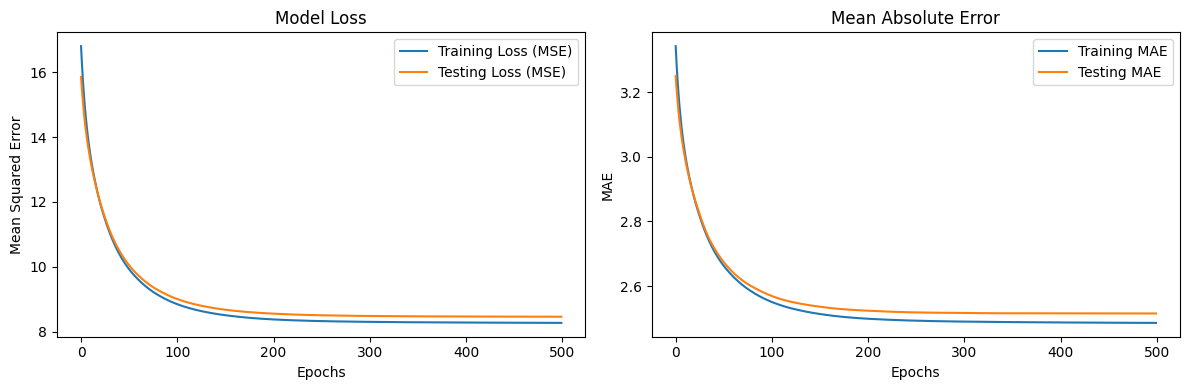

Epoch 1/500 - Loss: 15.9769 - MAE: 3.2591 - Accuracy: 0.0000
Epoch 2/500 - Loss: 15.5149 - MAE: 3.2158 - Accuracy: 0.0000
Epoch 3/500 - Loss: 15.0990 - MAE: 3.1762 - Accuracy: 0.0000
Epoch 4/500 - Loss: 14.7155 - MAE: 3.1390 - Accuracy: 0.0000
Epoch 5/500 - Loss: 14.3643 - MAE: 3.1051 - Accuracy: 0.0000
Epoch 6/500 - Loss: 14.0400 - MAE: 3.0726 - Accuracy: 0.0000
Epoch 7/500 - Loss: 13.7417 - MAE: 3.0427 - Accuracy: 0.0000
Epoch 8/500 - Loss: 13.4648 - MAE: 3.0153 - Accuracy: 0.0000
Epoch 9/500 - Loss: 13.2061 - MAE: 2.9900 - Accuracy: 0.0000
Epoch 10/500 - Loss: 12.9640 - MAE: 2.9658 - Accuracy: 0.0000
Epoch 11/500 - Loss: 12.7373 - MAE: 2.9428 - Accuracy: 0.0000
Epoch 12/500 - Loss: 12.5240 - MAE: 2.9214 - Accuracy: 0.0000
Epoch 13/500 - Loss: 12.3221 - MAE: 2.9012 - Accuracy: 0.0000
Epoch 14/500 - Loss: 12.1332 - MAE: 2.8824 - Accuracy: 0.0000
Epoch 15/500 - Loss: 11.9561 - MAE: 2.8648 - Accuracy: 0.0000
Epoch 16/500 - Loss: 11.7876 - MAE: 2.8483 - Accuracy: 0.0000
Epoch 17/500 - Lo

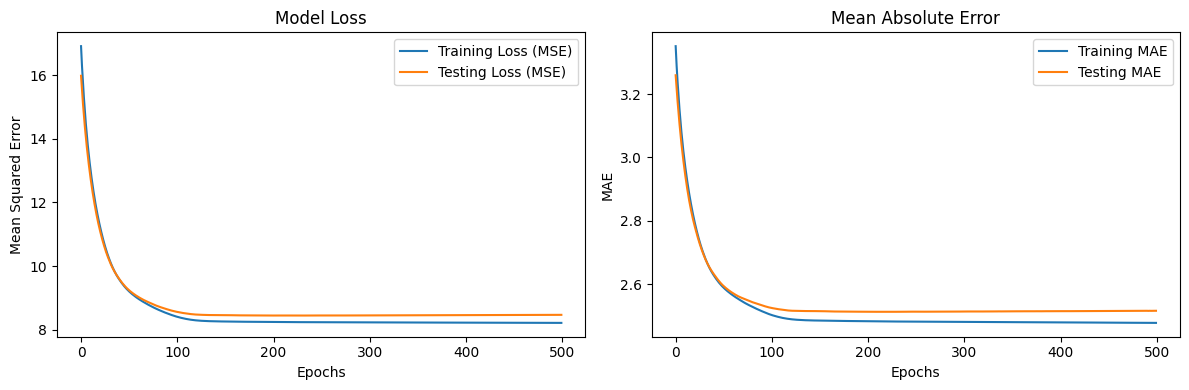

Epoch 1/500 - Loss: 15.8589 - MAE: 3.2503 - Accuracy: 0.0000
Epoch 2/500 - Loss: 15.2687 - MAE: 3.1951 - Accuracy: 0.0000
Epoch 3/500 - Loss: 14.7551 - MAE: 3.1458 - Accuracy: 0.0000
Epoch 4/500 - Loss: 14.2915 - MAE: 3.1018 - Accuracy: 0.0000
Epoch 5/500 - Loss: 13.8677 - MAE: 3.0609 - Accuracy: 0.0000
Epoch 6/500 - Loss: 13.4823 - MAE: 3.0233 - Accuracy: 0.0000
Epoch 7/500 - Loss: 13.1302 - MAE: 2.9890 - Accuracy: 0.0000
Epoch 8/500 - Loss: 12.8149 - MAE: 2.9581 - Accuracy: 0.0000
Epoch 9/500 - Loss: 12.5273 - MAE: 2.9294 - Accuracy: 0.0000
Epoch 10/500 - Loss: 12.2737 - MAE: 2.9041 - Accuracy: 0.0000
Epoch 11/500 - Loss: 12.0435 - MAE: 2.8813 - Accuracy: 0.0000
Epoch 12/500 - Loss: 11.8316 - MAE: 2.8602 - Accuracy: 0.0000
Epoch 13/500 - Loss: 11.6386 - MAE: 2.8408 - Accuracy: 0.0000
Epoch 14/500 - Loss: 11.4638 - MAE: 2.8231 - Accuracy: 0.0000
Epoch 15/500 - Loss: 11.3034 - MAE: 2.8068 - Accuracy: 0.0000
Epoch 16/500 - Loss: 11.1571 - MAE: 2.7920 - Accuracy: 0.0000
Epoch 17/500 - Lo

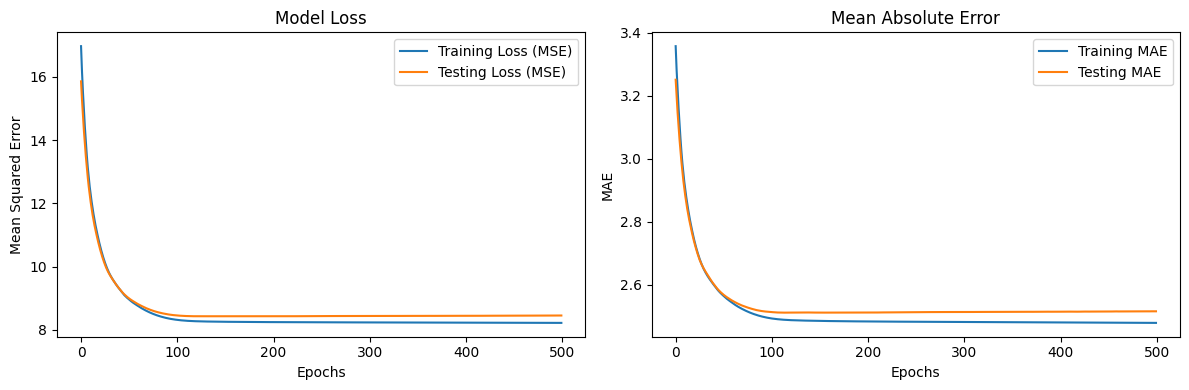

In [30]:
model1 = StackDepthRegressor(X.shape[1])
model2 = StackDepthRegressorTwo(X.shape[1])
model3 = StackDepthRegressorThree(X.shape[1])
model4 = StackDepthRegressorFour(X.shape[1])

print("Stack Depth Regression Results:")
stack_depth_results1, acc1 = train_and_evaluate(X, y, model2)
stack_depth_results2, acc2 = train_and_evaluate(X, y, model3)
stack_depth_results3, acc3 = train_and_evaluate(X, y, model1)
stack_depth_results4, acc4 = train_and_evaluate(X, y, model4)



Control Task Regression Results:
Epoch 1/500 - Loss: 23.9477 - MAE: 4.0407 - Accuracy: 0.0000
Epoch 2/500 - Loss: 23.9447 - MAE: 4.0402 - Accuracy: 0.0000
Epoch 3/500 - Loss: 23.9392 - MAE: 4.0397 - Accuracy: 0.0000
Epoch 4/500 - Loss: 23.9323 - MAE: 4.0390 - Accuracy: 0.0000
Epoch 5/500 - Loss: 23.9248 - MAE: 4.0383 - Accuracy: 0.0000
Epoch 6/500 - Loss: 23.9171 - MAE: 4.0376 - Accuracy: 0.0000
Epoch 7/500 - Loss: 23.9090 - MAE: 4.0368 - Accuracy: 0.0000
Epoch 8/500 - Loss: 23.9007 - MAE: 4.0359 - Accuracy: 0.0000
Epoch 9/500 - Loss: 23.8926 - MAE: 4.0351 - Accuracy: 0.0000
Epoch 10/500 - Loss: 23.8852 - MAE: 4.0343 - Accuracy: 0.0000
Epoch 11/500 - Loss: 23.8783 - MAE: 4.0335 - Accuracy: 0.0000
Epoch 12/500 - Loss: 23.8719 - MAE: 4.0329 - Accuracy: 0.0000
Epoch 13/500 - Loss: 23.8653 - MAE: 4.0322 - Accuracy: 0.0000
Epoch 14/500 - Loss: 23.8579 - MAE: 4.0314 - Accuracy: 0.0000
Epoch 15/500 - Loss: 23.8497 - MAE: 4.0306 - Accuracy: 0.0000
Epoch 16/500 - Loss: 23.8408 - MAE: 4.0298 - 

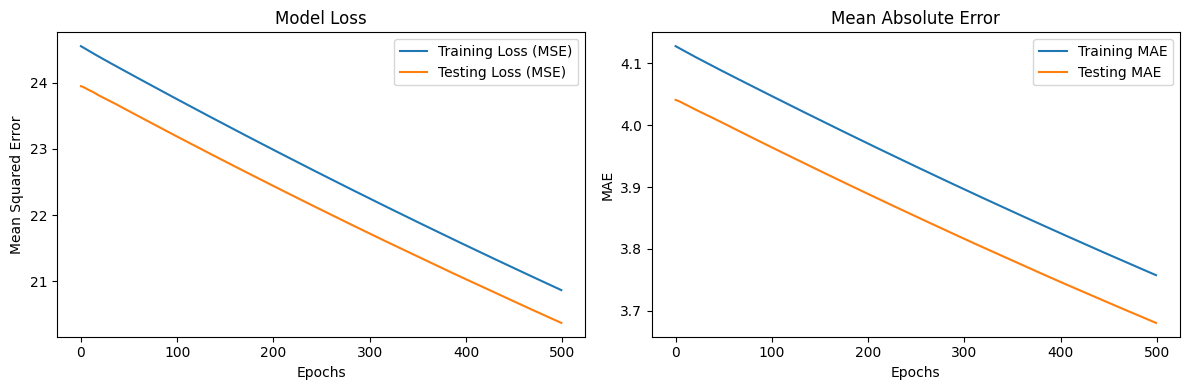

Epoch 1/500 - Loss: 8.4662 - MAE: 2.5154 - Accuracy: 0.0000
Epoch 2/500 - Loss: 8.4634 - MAE: 2.5157 - Accuracy: 0.0000
Epoch 3/500 - Loss: 8.4470 - MAE: 2.5133 - Accuracy: 0.0000
Epoch 4/500 - Loss: 8.4520 - MAE: 2.5138 - Accuracy: 0.0000
Epoch 5/500 - Loss: 8.4602 - MAE: 2.5152 - Accuracy: 0.0000
Epoch 6/500 - Loss: 8.4684 - MAE: 2.5164 - Accuracy: 0.0000
Epoch 7/500 - Loss: 8.4694 - MAE: 2.5165 - Accuracy: 0.0000
Epoch 8/500 - Loss: 8.4635 - MAE: 2.5157 - Accuracy: 0.0000
Epoch 9/500 - Loss: 8.4565 - MAE: 2.5147 - Accuracy: 0.0000
Epoch 10/500 - Loss: 8.4521 - MAE: 2.5140 - Accuracy: 0.0000
Epoch 11/500 - Loss: 8.4506 - MAE: 2.5139 - Accuracy: 0.0000
Epoch 12/500 - Loss: 8.4513 - MAE: 2.5142 - Accuracy: 0.0000
Epoch 13/500 - Loss: 8.4530 - MAE: 2.5146 - Accuracy: 0.0000
Epoch 14/500 - Loss: 8.4537 - MAE: 2.5148 - Accuracy: 0.0000
Epoch 15/500 - Loss: 8.4536 - MAE: 2.5148 - Accuracy: 0.0000
Epoch 16/500 - Loss: 8.4540 - MAE: 2.5148 - Accuracy: 0.0000
Epoch 17/500 - Loss: 8.4551 - MAE

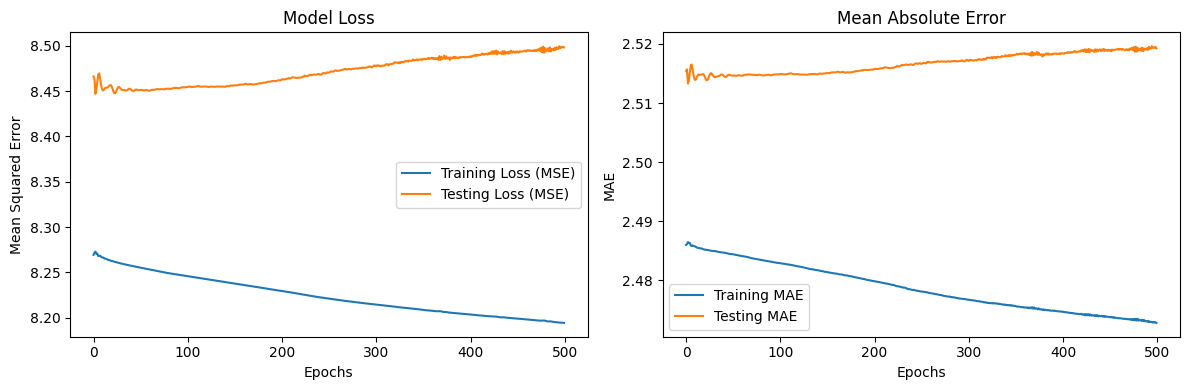

Epoch 1/500 - Loss: 8.4892 - MAE: 2.5177 - Accuracy: 0.0000
Epoch 2/500 - Loss: 8.4661 - MAE: 2.5157 - Accuracy: 0.0000
Epoch 3/500 - Loss: 8.4926 - MAE: 2.5194 - Accuracy: 0.0000
Epoch 4/500 - Loss: 8.4741 - MAE: 2.5161 - Accuracy: 0.0000
Epoch 5/500 - Loss: 8.4772 - MAE: 2.5162 - Accuracy: 0.0000
Epoch 6/500 - Loss: 8.4916 - MAE: 2.5183 - Accuracy: 0.0000
Epoch 7/500 - Loss: 8.4975 - MAE: 2.5190 - Accuracy: 0.0000
Epoch 8/500 - Loss: 8.4836 - MAE: 2.5170 - Accuracy: 0.0000
Epoch 9/500 - Loss: 8.4704 - MAE: 2.5152 - Accuracy: 0.0000
Epoch 10/500 - Loss: 8.4651 - MAE: 2.5147 - Accuracy: 0.0000
Epoch 11/500 - Loss: 8.4676 - MAE: 2.5155 - Accuracy: 0.0000
Epoch 12/500 - Loss: 8.4737 - MAE: 2.5165 - Accuracy: 0.0000
Epoch 13/500 - Loss: 8.4735 - MAE: 2.5165 - Accuracy: 0.0000
Epoch 14/500 - Loss: 8.4702 - MAE: 2.5158 - Accuracy: 0.0000
Epoch 15/500 - Loss: 8.4706 - MAE: 2.5158 - Accuracy: 0.0000
Epoch 16/500 - Loss: 8.4756 - MAE: 2.5164 - Accuracy: 0.0000
Epoch 17/500 - Loss: 8.4831 - MAE

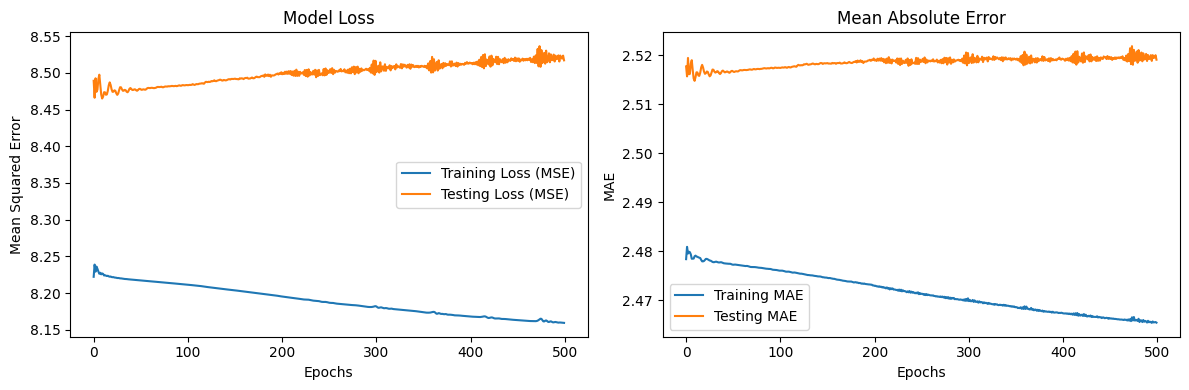

Epoch 1/500 - Loss: 8.4760 - MAE: 2.5159 - Accuracy: 0.0000
Epoch 2/500 - Loss: 8.4967 - MAE: 2.5207 - Accuracy: 0.0000
Epoch 3/500 - Loss: 8.5225 - MAE: 2.5239 - Accuracy: 0.0000
Epoch 4/500 - Loss: 8.4775 - MAE: 2.5182 - Accuracy: 0.0000
Epoch 5/500 - Loss: 8.4433 - MAE: 2.5135 - Accuracy: 0.0000
Epoch 6/500 - Loss: 8.4378 - MAE: 2.5125 - Accuracy: 0.0000
Epoch 7/500 - Loss: 8.4396 - MAE: 2.5129 - Accuracy: 0.0000
Epoch 8/500 - Loss: 8.4504 - MAE: 2.5145 - Accuracy: 0.0000
Epoch 9/500 - Loss: 8.4739 - MAE: 2.5175 - Accuracy: 0.0000
Epoch 10/500 - Loss: 8.4934 - MAE: 2.5201 - Accuracy: 0.0000
Epoch 11/500 - Loss: 8.4926 - MAE: 2.5198 - Accuracy: 0.0000
Epoch 12/500 - Loss: 8.4776 - MAE: 2.5177 - Accuracy: 0.0000
Epoch 13/500 - Loss: 8.4632 - MAE: 2.5156 - Accuracy: 0.0000
Epoch 14/500 - Loss: 8.4546 - MAE: 2.5144 - Accuracy: 0.0000
Epoch 15/500 - Loss: 8.4497 - MAE: 2.5139 - Accuracy: 0.0000
Epoch 16/500 - Loss: 8.4495 - MAE: 2.5141 - Accuracy: 0.0000
Epoch 17/500 - Loss: 8.4559 - MAE

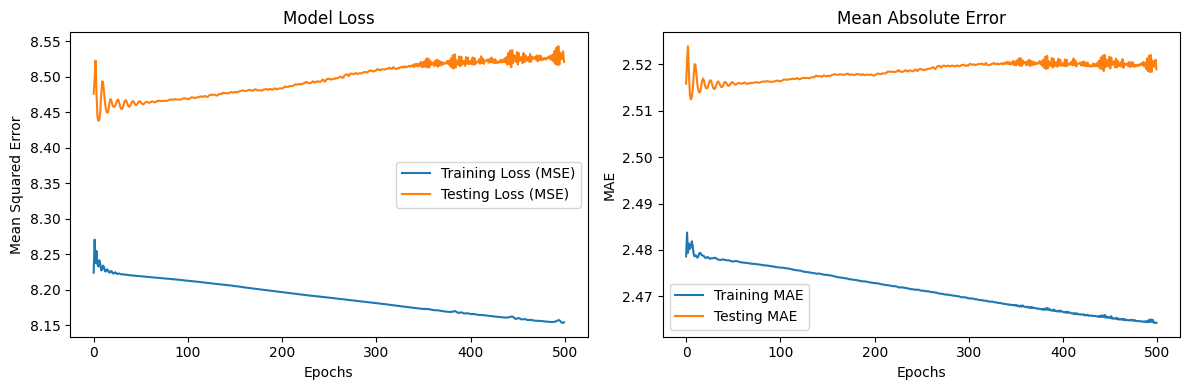

In [33]:

# Train and evaluate control task
print("\nControl Task Regression Results:")
control_results1, acc_control1, train_acc_control1 = train_and_evaluate_control(X_control, y_control, model2)
control_results2, acc_control2, train_acc_control2 = train_and_evaluate_control(X_control, y_control, model3)
control_results3, acc_control3, train_acc_control3 = train_and_evaluate_control(X_control, y_control, model1)
control_results4, acc_control4, train_acc_control4= train_and_evaluate_control(X_control, y_control, model4)

In [34]:
train_accs_control = [train_acc_control1[-1], train_acc_control2[-1], train_acc_control3[-1], train_acc_control4[-1]]

NameError: name 'labels' is not defined

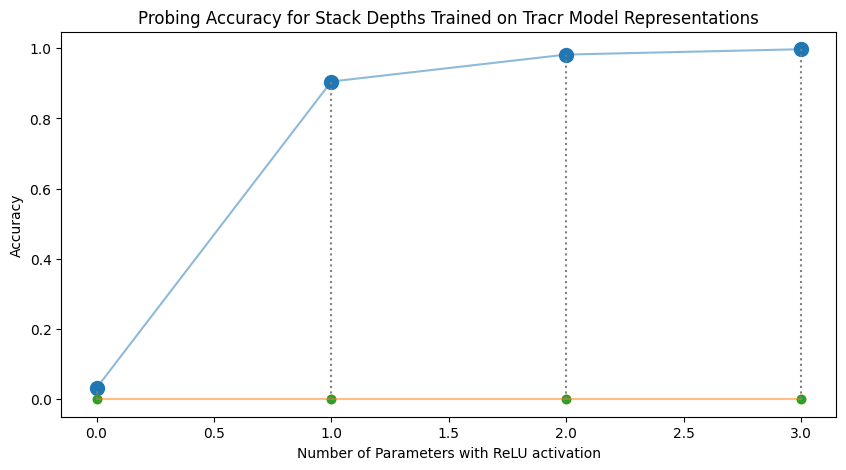

In [36]:
task_accs = [acc1[-1], acc2[-1], acc3[-1], acc4[-1]]
control_accs = [acc_control1[-1], acc_control2[-1], acc_control3[-1], acc_control4[-1]]

# labels = ['10110 (1 layer)', '3316 (2 layers)', '9204 (3 layers)', '10772 (4 layers)']

plt.figure(figsize=(10, 5))
plt.scatter(range(len(task_accs)), task_accs, label='Stack Depth Testing Accuracy', s=100)  # Increase point size
plt.scatter(range(len(control_accs)), control_accs, label='Control Testing Accuracy')
plt.scatter(range(len(train_accs_control)), train_accs_control, label='Control Training Accuracy')
# Add transparent line for task_accs
plt.plot(range(len(task_accs)), task_accs, alpha=0.5)
plt.plot(range(len(control_accs)), control_accs, alpha=0.5)

# Add vertical lines between corresponding points
for i in range(len(task_accs)):
    plt.vlines(i, min(task_accs[i], control_accs[i]), max(task_accs[i], control_accs[i]), colors='gray', linestyles='dotted')

plt.title('Probing Accuracy for Stack Depths Trained on Tracr Model Representations')
plt.ylabel('Accuracy')
plt.xlabel('Number of Parameters with ReLU activation')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Save the figure in high resolution
# plt.savefig('high_res_plot_task.png', dpi=300)

plt.show()

In [ ]:
# labels = ['10110 (1 layer)', '3316 (2 layers)', '9204 (3 layers)', '10772 (4 layers)']

plt.figure(figsize=(10, 5))
plt.scatter(range(len(task_accs)), task_accs, label='Stack Depth Testing Accuracy', s=100)  # Increase point size
plt.scatter(range(len(control_accs)), control_accs, label='Control Testing Accuracy')
plt.scatter(range(len(task_train_accs)), task_train_accs, label='Stack Depth Training Accuracy', s=100)  # Increase point size
plt.scatter(range(len(control_train_accs)), control_train_accs, label='Control Training Accuracy')

# Add transparent line for task_accs
plt.plot(range(len(task_accs)), task_accs, alpha=0.5)
plt.plot(range(len(control_accs)), control_accs, alpha=0.5)
plt.plot(range(len(task_train_accs)), task_train_accs, alpha=0.5)
plt.plot(range(len(control_train_accs)), control_train_accs, alpha=0.5)

# Add vertical lines between corresponding points
for i in range(len(task_accs)):
    plt.vlines(i, min(task_accs[i], control_accs[i]), max(task_accs[i], control_accs[i]), colors='gray', linestyles='dotted')

plt.title('Probing Accuracy for Stack Depths Trained on Tracr Model Representations')
plt.ylabel('Accuracy')
plt.xlabel('Number of Parameters with ReLU activation')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Save the figure in high resolution
plt.savefig('high_res_plot_task.png', dpi=300)

plt.show()

In [ ]:
    # Print final metrics
    print(f"\nFinal Stack Depth Training MAE: {stack_depth_results['train_mae'][-1]:.4f}")
    print(f"Final Stack Depth Testing MAE: {stack_depth_results['test_mae'][-1]:.4f}")
    print(f"\nFinal Control Task Training MAE: {control_results['train_mae'][-1]:.4f}")
    print(f"Final Control Task Testing MAE: {control_results['test_mae'][-1]:.4f}")

In [20]:
import torch
from sklearn.preprocessing import StandardScaler

def evaluate_model(model, X_test, y_test, scaler):
    """
    Evaluate the regression model by calculating accuracy.
    
    Args:
        model: Trained regression model
        X_test (np.array): Test features
        y_test (np.array): Test labels
        scaler (StandardScaler): Scaler used for standardizing features
    
    Returns:
        float: Accuracy of the model
    """
    # Standardize test features
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.FloatTensor(y_test)
    
    # Set model to evaluation mode
    model.eval()
    
    # Perform forward pass
    with torch.no_grad():
        outputs = model(X_test_tensor)
    
    # Round the predictions to the nearest integer
    rounded_predictions = torch.round(outputs)
    
    # Calculate accuracy
    correct_predictions = (rounded_predictions == y_test_tensor).sum().item()
    accuracy = correct_predictions / len(y_test_tensor)
    
    return accuracy

In [21]:
evaluate_model(model, X_test, y_test, scaler)

NameError: name 'model' is not defined

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class StackLengthClassifierSimple(nn.Module):
    def __init__(self, input_size):
        """
        Simple linear classifier for stack length prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackLengthClassifierSimple, self).__init__()
        self.linear = nn.Linear(input_size, 100)
    
    def forward(self, x):
        x = self.linear(x)
        return x

class StackLengthClassifierSecond(nn.Module):
    def __init__(self, input_size):
        """
        Simple linear classifier for stack length prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackLengthClassifierSecond, self).__init__()
        self.linear = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16, 100)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

class StackLengthClassifierThird(nn.Module):
    def __init__(self, input_size):
        """
        Simple linear classifier for stack length prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackLengthClassifierThird, self).__init__()
        self.linear = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16, 64)
        self.linear3 = nn.Linear(64, 100)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        return x

class StackLengthClassifierLast(nn.Module):
    def __init__(self, input_size):
        """
        Simple linear classifier for stack length prediction
        
        Args:
            input_size (int): Size of input features
        """
        super(StackLengthClassifierLast, self).__init__()
        self.linear = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 16)
        self.linear4 = nn.Linear(16, 100)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.relu(x)
        x = self.linear4(x)
        return x


def train_and_evaluate(X, y, probe_model, epochs=500):
    """
    Train a linear classifier and evaluate its performance
    
    Args:
        X (np.array): Input features
        y (np.array): Stack length labels
    
    Returns:
        dict: Training history with accuracies
    """
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    y_train_tensor = torch.LongTensor(y_train)
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    y_test_tensor = torch.LongTensor(y_test)
    
    # Instantiate the model
    model = probe_model
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training parameters
    epochs = 500
    batch_size = 32
    
    # Training history
    train_accuracies = []
    test_accuracies = []
    
    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Compute training accuracy
        with torch.no_grad():
            train_pred = outputs.argmax(dim=1)
            train_accuracy = (train_pred == y_train_tensor).float().mean().item()
            train_accuracies.append(train_accuracy)
        
        # Compute test accuracy
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_pred = test_outputs.argmax(dim=1)
            test_accuracy = (test_pred == y_test_tensor).float().mean().item()
            test_accuracies.append(test_accuracy)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Testing Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return {
        'train_accuracies': train_accuracies, 
        'test_accuracies': test_accuracies
    }


In [11]:
model1 = StackLengthClassifierSimple(input_size=X.shape[1])
model2 = StackLengthClassifierSecond(input_size=X.shape[1])
model3 = StackLengthClassifierThird(input_size=X.shape[1])
model4 = StackLengthClassifierLast(input_size=X.shape[1])

In [ ]:
results = train_and_evaluate(X, y, model1, epochs=10000)
# Print final accuracies
print(f"Final Training Accuracy: {results['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results['test_accuracies'][-1]:.4f}")

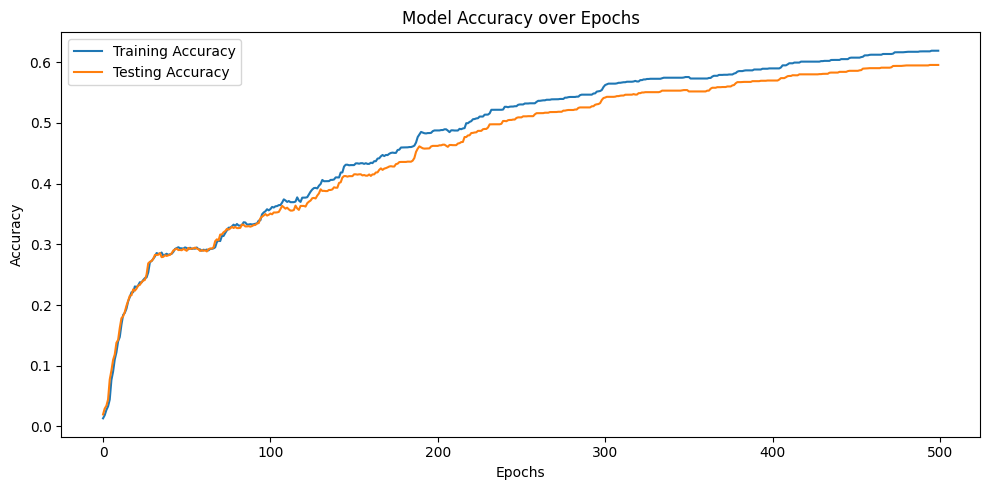

Final Training Accuracy: 0.6190
Final Testing Accuracy: 0.5955


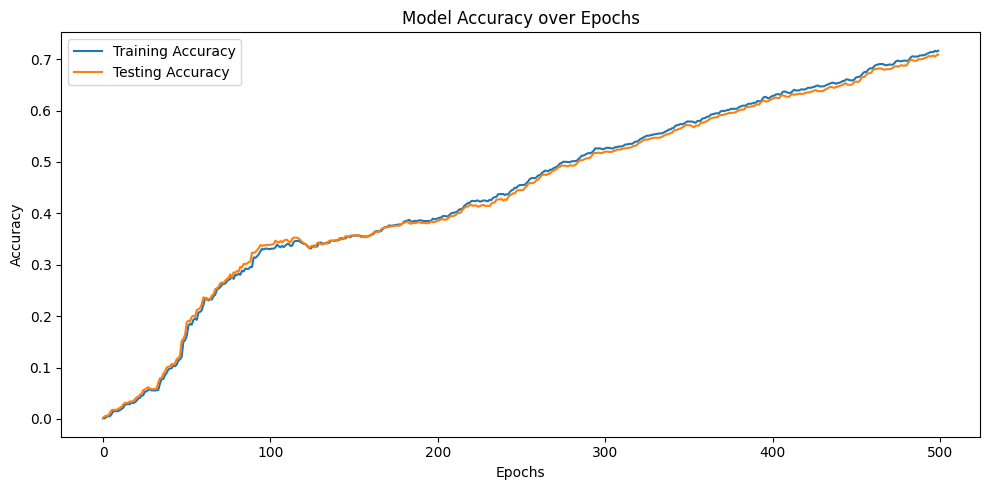

Final Training Accuracy: 0.7164
Final Testing Accuracy: 0.7089


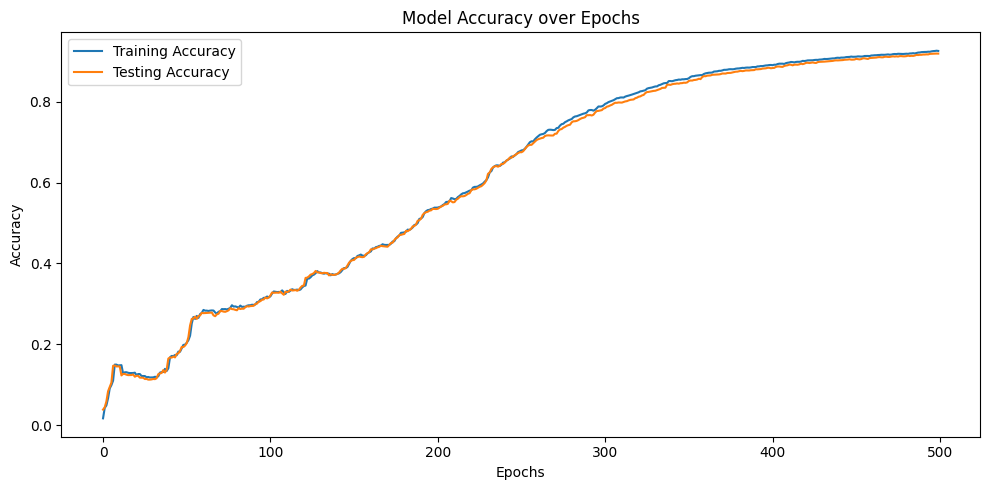

Final Training Accuracy: 0.9258
Final Testing Accuracy: 0.9192


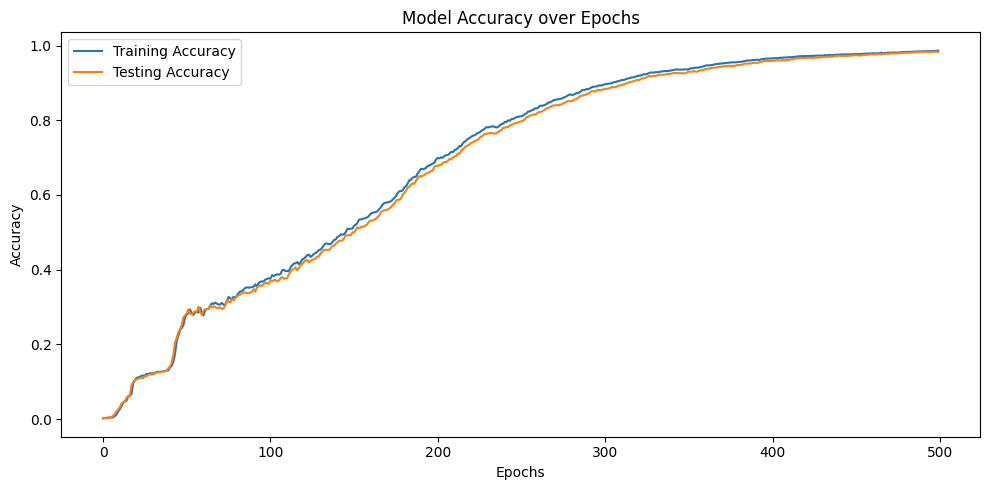

Final Training Accuracy: 0.9864
Final Testing Accuracy: 0.9835


In [12]:
results = train_and_evaluate(X, y, model1, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results['test_accuracies'][-1]:.4f}")

results2 = train_and_evaluate(X, y, model2, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results2['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results2['test_accuracies'][-1]:.4f}")

results3 = train_and_evaluate(X, y, model3, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results3['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results3['test_accuracies'][-1]:.4f}")

results4 = train_and_evaluate(X, y, model4, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results4['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results4['test_accuracies'][-1]:.4f}")

In [13]:
print(f"Final Training Accuracy: {results['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results['test_accuracies'][-1]:.4f}")

print(f"Final Training Accuracy: {results2['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results2['test_accuracies'][-1]:.4f}")

print(f"Final Training Accuracy: {results3['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results3['test_accuracies'][-1]:.4f}")

print(f"Final Training Accuracy: {results4['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results4['test_accuracies'][-1]:.4f}")

Final Training Accuracy: 0.6190
Final Testing Accuracy: 0.5955
Final Training Accuracy: 0.7164
Final Testing Accuracy: 0.7089
Final Training Accuracy: 0.9258
Final Testing Accuracy: 0.9192
Final Training Accuracy: 0.9864
Final Testing Accuracy: 0.9835


In [24]:
X_control, y_control = generate_control_dataset(mock_model, num_sequences=100)

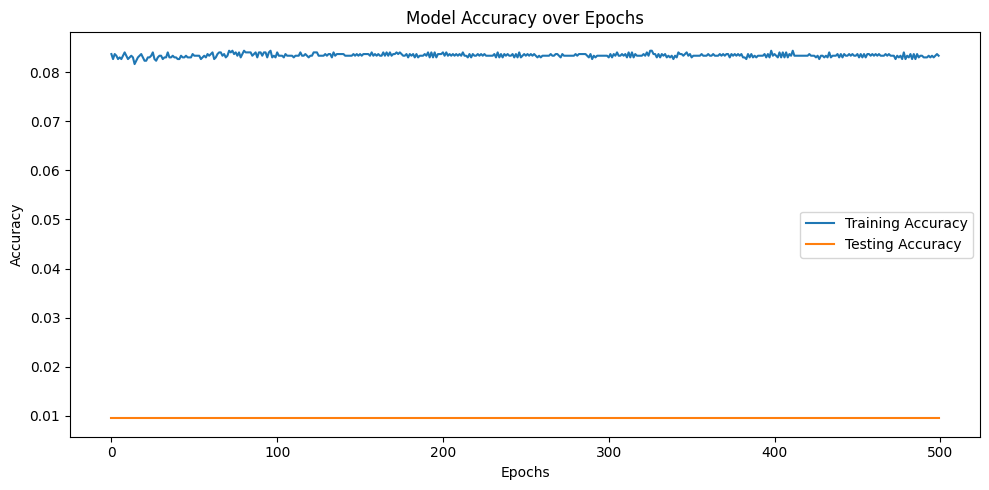

Final Training Accuracy: 0.0833
Final Testing Accuracy: 0.0095


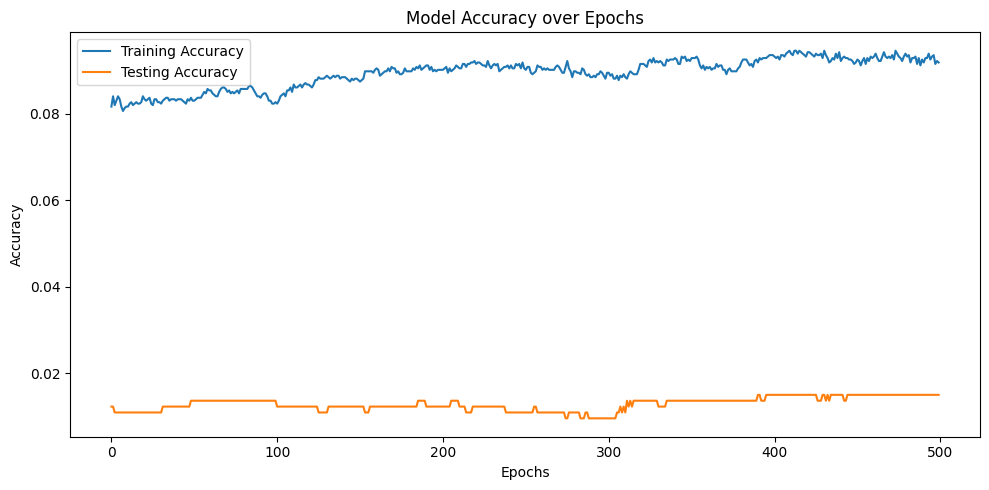

Final Training Accuracy: 0.0918
Final Testing Accuracy: 0.0149


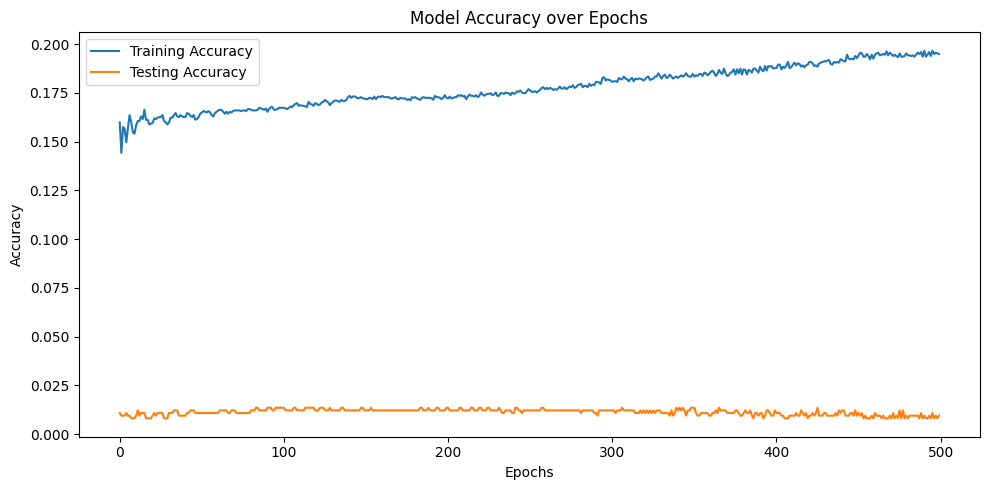

Final Training Accuracy: 0.1949
Final Testing Accuracy: 0.0095


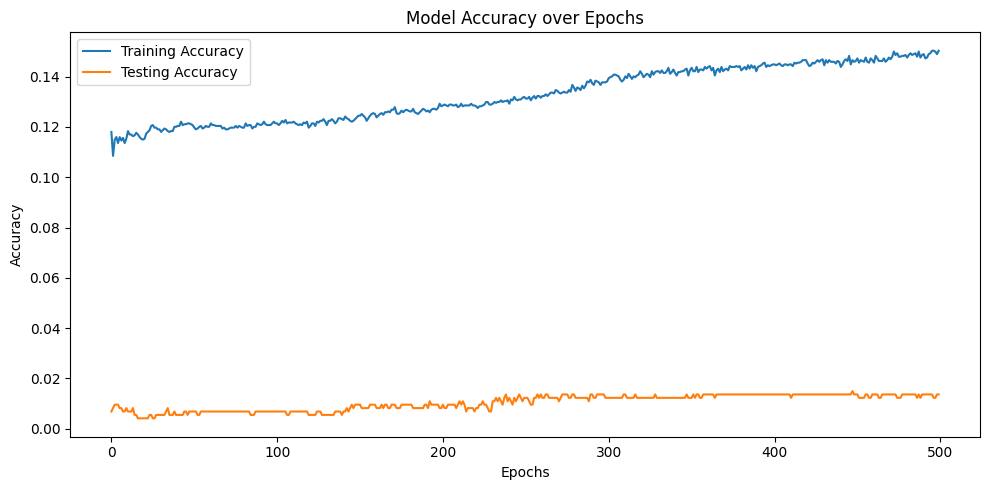

Final Training Accuracy: 0.1503
Final Testing Accuracy: 0.0136


In [30]:
results_control = train_and_evaluate(X_control, y_control, model1, epochs=10000)
# Print final accuracies
print(f"Final Training Accuracy: {results_control['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results_control['test_accuracies'][-1]:.4f}")

results_control2 = train_and_evaluate(X_control, y_control, model2, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results_control2['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results_control2['test_accuracies'][-1]:.4f}")

results_control3 = train_and_evaluate(X_control, y_control, model3, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results_control3['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results_control3['test_accuracies'][-1]:.4f}")

results_control4 = train_and_evaluate(X_control, y_control, model4, epochs=1000)
# Print final accuracies
print(f"Final Training Accuracy: {results_control4['train_accuracies'][-1]:.4f}")
print(f"Final Testing Accuracy: {results_control4['test_accuracies'][-1]:.4f}")

In [31]:
print(results_control['train_accuracies'][-1])
print(results_control['test_accuracies'][-1])

print(results_control2['train_accuracies'][-1])
print(results_control2['test_accuracies'][-1])

print(results_control3['train_accuracies'][-1])
print(results_control3['test_accuracies'][-1])

print(results_control4['train_accuracies'][-1])
print(results_control4['test_accuracies'][-1])

0.0833333358168602
0.009510869160294533
0.09183673560619354
0.014945652335882187
0.19489796459674835
0.009510869160294533
0.15034013986587524
0.013586956076323986


In [32]:
task_accs = [results['test_accuracies'][-1], results2['test_accuracies'][-1], results3['test_accuracies'][-1], results4['test_accuracies'][-1]]
control_accs = [results_control['test_accuracies'][-1], results_control2['test_accuracies'][-1], results_control3['test_accuracies'][-1], results_control4['test_accuracies'][-1]]
task_train_accs = [results['train_accuracies'][-1], results2['train_accuracies'][-1], results3['train_accuracies'][-1], results4['train_accuracies'][-1]]
control_train_accs = [results_control['train_accuracies'][-1], results_control2['train_accuracies'][-1], results_control3['train_accuracies'][-1], results_control4['train_accuracies'][-1]]

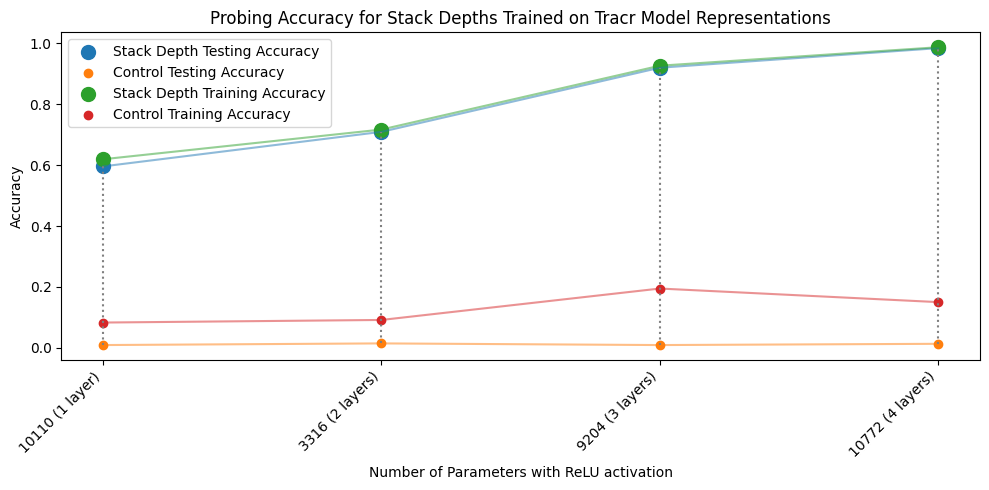

In [45]:
labels = ['10110 (1 layer)', '3316 (2 layers)', '9204 (3 layers)', '10772 (4 layers)']

plt.figure(figsize=(10, 5))
plt.scatter(range(len(task_accs)), task_accs, label='Stack Depth Testing Accuracy', s=100)  # Increase point size
plt.scatter(range(len(control_accs)), control_accs, label='Control Testing Accuracy')
plt.scatter(range(len(task_train_accs)), task_train_accs, label='Stack Depth Training Accuracy', s=100)  # Increase point size
plt.scatter(range(len(control_train_accs)), control_train_accs, label='Control Training Accuracy')

# Add transparent line for task_accs
plt.plot(range(len(task_accs)), task_accs, alpha=0.5)
plt.plot(range(len(control_accs)), control_accs, alpha=0.5)
plt.plot(range(len(task_train_accs)), task_train_accs, alpha=0.5)
plt.plot(range(len(control_train_accs)), control_train_accs, alpha=0.5)

# Add vertical lines between corresponding points
for i in range(len(task_accs)):
    plt.vlines(i, min(task_accs[i], control_accs[i]), max(task_accs[i], control_accs[i]), colors='gray', linestyles='dotted')

plt.title('Probing Accuracy for Stack Depths Trained on Tracr Model Representations')
plt.ylabel('Accuracy')
plt.xlabel('Number of Parameters with ReLU activation')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Save the figure in high resolution
plt.savefig('high_res_plot_task.png', dpi=300)

plt.show()